In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV ,KFold
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import cross_val_score

In [2]:
best_models={}
def best_model(model,main_score,params):
    best_models[model]={
            'best_score':main_score,
            'best_params':params
        }
    return best_models

In [3]:
from sklearn.calibration import LabelEncoder
df = pd.read_csv('Data/colon-dataset-processed.csv')
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])
df

,Class,Age,p16540_C/C,p16540_G/C,p16540_G/G,p16580_C/C,p16580_C/T,p16580_T/T,mdm2_G/G,mdm2_G/T,mdm2_T/T,GAL3_A/A,GAL3_C/A,GAL3_C/C,TIM1_C/C,TIM1_G/C,TIM1_G/G
0,1,49,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False
1,1,49,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False
2,1,49,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False
3,1,36,False,True,False,True,False,False,False,False,True,False,True,False,True,False,False
4,1,49,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,81,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True
111,0,73,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True
112,0,56,True,False,False,True,False,False,False,True,False,False,False,True,False,True,False
113,0,74,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True


In [4]:
data=df.drop(['Class'],axis=1)
target=df['Class']
print('Original dataset distribution %s' % Counter(target))
random_state=42


Original dataset distribution Counter({0: 65, 1: 50})


# Oreginal data 

In [6]:

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3,random_state=random_state)

adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

y_pred_Org= adaboost.predict(X_test)
print("Accuracy: %.2f%%" % (adaboost.score(X_test, y_test) * 100.0))

Accuracy: 88.57%


In [ ]:
#save the model
import pickle
filename = 'Models/AdaBoost_model.pkl'
pickle.dump(adaboost, open(filename, 'wb'))

In [236]:
# Perform cross-validation
n_splits = 35
cv_scores = cross_val_score(adaboost, data, target, cv=n_splits, scoring='accuracy')

# Calculate the average of the cross-validation scores
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy over %d-fold cross-validation: %.2f%%" % (n_splits, average_accuracy*100))


Average Accuracy over 35-fold cross-validation: 84.52%


In [237]:
best_model('adaboost orgein data',average_accuracy*100,adaboost.get_params())

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}}}

              precision    recall  f1-score   support

   diagnosed       0.89      0.89      0.89        18
     healthy       0.88      0.88      0.88        17

    accuracy                           0.89        35
   macro avg       0.89      0.89      0.89        35
weighted avg       0.89      0.89      0.89        35



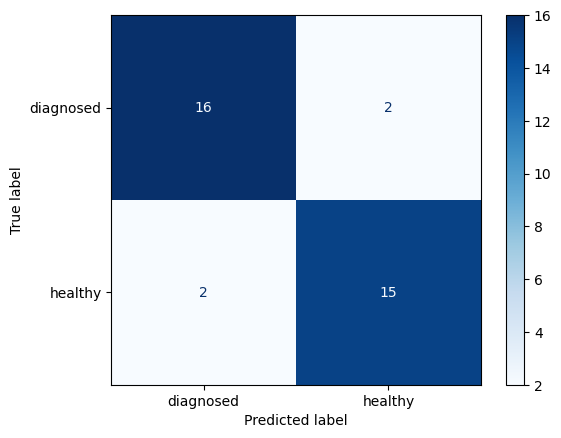

In [238]:

print(classification_report(y_test, y_pred_Org))
cm=confusion_matrix(y_test, y_pred_Org)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [239]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200], # Number of weak learners to train iteratively
    'learning_rate': [0.01, 0.1, 1], # Contribution of each classifier
}
cv=KFold(n_splits=4, random_state=random_state, shuffle=True)
# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(adaboost, param_grid, cv=cv, scoring='accuracy', n_jobs=-1,error_score=0)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True), error_score=0,
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [240]:
# Print the best parameters and their corresponding accuracy
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy: %.2f%% " % (grid_search.best_score_*100.0))

# Evaluate on the test set
y_pred_OrgGr = grid_search.predict(X_test)
print("Accuracy with Grid search: %.2f%%" % (grid_search.score(X_test, y_test) * 100.0))


Best parameters found: {'learning_rate': 0.01, 'n_estimators': 50}
Best cross-validation accuracy: 86.25% 
Accuracy with Grid search: 80.00%


In [241]:
# Perform cross-validation
n_splits = 35
cv_scores = cross_val_score(grid_search, data, target, cv=n_splits, scoring='accuracy')


In [242]:
# Calculate the average of the cross-validation scores
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy over %d-fold cross-validation: %.2f%%" % (n_splits, average_accuracy*100))
# 82.86%

Average Accuracy over 35-fold cross-validation: 82.86%


In [243]:
best_model("AdaBoost grid_search Org ",average_accuracy*100,grid_search.best_params_)

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost grid_search Org ': {'best_score': 82.85714285714286,
  'best_params': {'learning_rate': 0.01, 'n_estimators': 50}}}

              precision    recall  f1-score   support

   diagnosed       0.79      0.83      0.81        18
     healthy       0.81      0.76      0.79        17

    accuracy                           0.80        35
   macro avg       0.80      0.80      0.80        35
weighted avg       0.80      0.80      0.80        35



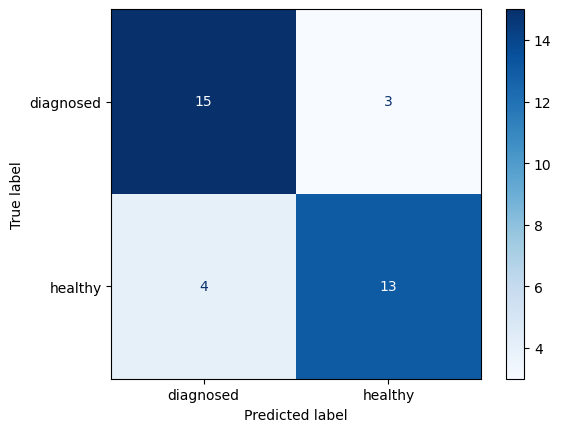

In [244]:

print(classification_report(y_test, y_pred_OrgGr))
cm=confusion_matrix(y_test, y_pred_OrgGr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Oversampled

In [245]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(data, target)
X_train, X_test, y_train, y_test = train_test_split(X_train_res, y_train_res, test_size = 0.3,random_state=random_state)
print('Original dataset distribution %s' % Counter(y_train_res))
adaboost_smote = AdaBoostClassifier()
adaboost_smote.fit(X_train, y_train)
y_pred_SMOTE= adaboost_smote.predict(X_test)
print("Accuracy of SMOTE data: %.2f%%" % (adaboost_smote.score(X_test, y_test) * 100.0))
# 82.05%

Original dataset distribution Counter({'healthy': 65, 'diagnosed': 65})
Accuracy of SMOTE data: 82.05%


In [246]:
adaboost_smote.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [247]:
# Perform cross-validation
n_splits = 35
cv_scores = cross_val_score(adaboost_smote, X_train_res, y_train_res, cv=n_splits, scoring='accuracy')

# Calculate the average of the cross-validation scores
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy over %d-fold cross-validation: %.2f%%" % (n_splits, average_accuracy*100))

Average Accuracy over 35-fold cross-validation: 86.67%


In [248]:
best_model("AdaBoost Oversampel ",average_accuracy*100,adaboost_smote.get_params())

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost grid_search Org ': {'best_score': 82.85714285714286,
  'best_params': {'learning_rate': 0.01, 'n_estimators': 50}},
 'AdaBoost Oversampel ': {'best_score': 86.66666666666666,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}}}

              precision    recall  f1-score   support

   diagnosed       0.88      0.74      0.80        19
     healthy       0.78      0.90      0.84        20

    accuracy                           0.82        39
   macro avg       0.83      0.82      0.82        39
weighted avg       0.83      0.82      0.82        39



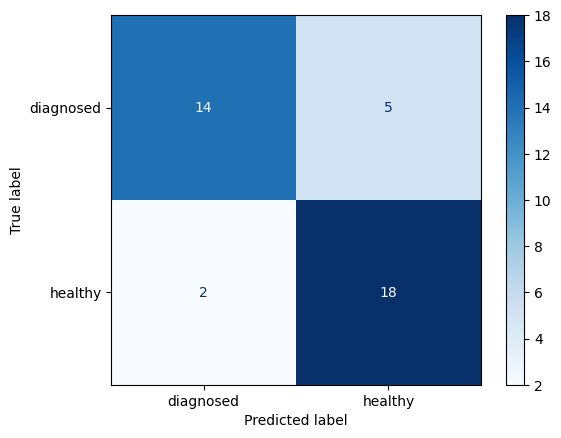

In [249]:

print(classification_report(y_test, y_pred_SMOTE))
cm=confusion_matrix(y_test, y_pred_SMOTE)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [250]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(adaboost_smote, param_grid, cv=KFold(n_splits=4, random_state=random_state, shuffle=True), scoring='accuracy', n_jobs=-1,error_score=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True), error_score=0,
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [251]:
# Print the best parameters and their corresponding accuracy
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy: %.2f%% " % (grid_search.best_score_*100.0))

# Evaluate on the test set
y_pred_SMOTEGr = grid_search.predict(X_test)
print("Accuracy of SMOTE data with Grid search: %.2f%%" % (grid_search.score(X_test, y_test) * 100.0))

Best parameters found: {'learning_rate': 0.001, 'n_estimators': 50}
Best cross-validation accuracy: 84.68% 
Accuracy of SMOTE data with Grid search: 87.18%


In [252]:
# Perform cross-validation
n_splits = 35
cv_scores = cross_val_score(grid_search, X_train_res, y_train_res, cv=n_splits, scoring='accuracy')

In [253]:
# Calculate the average of the cross-validation scores
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy over %d-fold cross-validation: %.2f%%" % (n_splits, average_accuracy*100))

Average Accuracy over 35-fold cross-validation: 88.10%


In [254]:
best_model("AdaBoost Grid search Oversampel ",average_accuracy*100,grid_search.best_params_)

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost grid_search Org ': {'best_score': 82.85714285714286,
  'best_params': {'learning_rate': 0.01, 'n_estimators': 50}},
 'AdaBoost Oversampel ': {'best_score': 86.66666666666666,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost Grid search Oversampel ': {'best_score': 88.09523809523809,
  'best_params': {'learning_rate': 0.001, 'n_estimators': 50}}}

              precision    recall  f1-score   support

   diagnosed       0.79      1.00      0.88        19
     healthy       1.00      0.75      0.86        20

    accuracy                           0.87        39
   macro avg       0.90      0.88      0.87        39
weighted avg       0.90      0.87      0.87        39



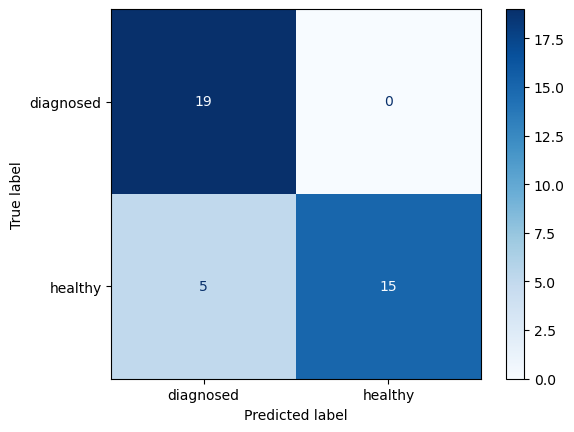

In [255]:
print(classification_report(y_test, y_pred_SMOTEGr))
cm=confusion_matrix(y_test, y_pred_SMOTEGr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Undersampling

In [256]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(data, target)
print('Original dataset distribution %s' % Counter(y_res))
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3,random_state=random_state)

adaboost_underSampler = AdaBoostClassifier()
adaboost_underSampler.fit(X_train, y_train)
y_pred_underSampler= adaboost_underSampler.predict(X_test)
print("Accuracy of SMOTE data: %.2f%%" % (adaboost_underSampler.score(X_test, y_test) * 100.0))


Original dataset distribution Counter({'diagnosed': 50, 'healthy': 50})
Accuracy of SMOTE data: 66.67%


In [257]:
# Perform cross-validation
n_splits = 35
cv_scores = cross_val_score(adaboost_underSampler, X_res, y_res, cv=n_splits, scoring='accuracy')

# Calculate the average of the cross-validation scores
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy over %d-fold cross-validation: %.2f%%" % (n_splits, average_accuracy*100))

Average Accuracy over 35-fold cross-validation: 81.90%


In [258]:
best_model("AdaBoost undersampel ",average_accuracy*100,adaboost_underSampler.get_params())

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost grid_search Org ': {'best_score': 82.85714285714286,
  'best_params': {'learning_rate': 0.01, 'n_estimators': 50}},
 'AdaBoost Oversampel ': {'best_score': 86.66666666666666,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost Grid search Oversampel ': {'best_score': 88.09523809523809,
  'best_params': {'learning_rate': 0.001, 'n_estimators': 50}},
 'AdaBoost undersampel ': {'best_score': 81.9047619047619,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}}}

              precision    recall  f1-score   support

   diagnosed       0.77      0.59      0.67        17
     healthy       0.59      0.77      0.67        13

    accuracy                           0.67        30
   macro avg       0.68      0.68      0.67        30
weighted avg       0.69      0.67      0.67        30



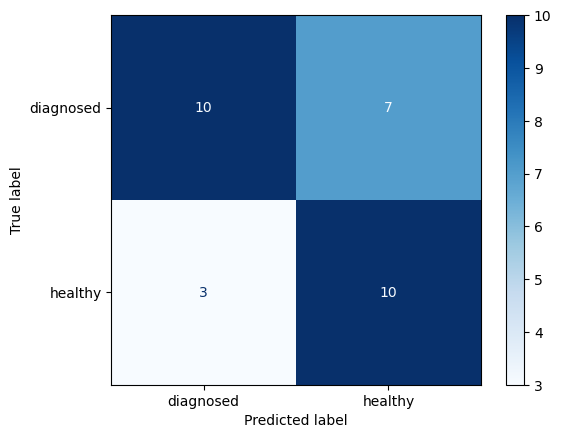

In [259]:
print(classification_report(y_test, y_pred_underSampler))
cm=confusion_matrix(y_test, y_pred_underSampler)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [260]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200], # Number of weak learners to train iteratively
    'learning_rate': [0.01, 0.1, 1], # Contribution of each classifier
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(adaboost_underSampler, param_grid, cv=KFold(n_splits=4, random_state=random_state, shuffle=True), scoring='accuracy', n_jobs=-1,error_score=0)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True), error_score=0,
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [261]:

# Print the best parameters and their corresponding accuracy
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy: %.2f%% " % (grid_search.best_score_*100.0))

# Evaluate on the test set
y_pred_underSamplerGr = grid_search.predict(X_test)
print("Accuracy of under sampleing data with Grid search: %.2f%%" % (grid_search.score(X_test, y_test) * 100.0))


Best parameters found: {'learning_rate': 0.1, 'n_estimators': 50}
Best cross-validation accuracy: 80.07% 
Accuracy of under sampleing data with Grid search: 73.33%


In [262]:
# Perform cross-validation
n_splits = 35
cv_scores = cross_val_score(grid_search, X_res, y_res, cv=n_splits, scoring='accuracy')


In [263]:

# Calculate the average of the cross-validation scores
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy over %d-fold cross-validation: %.2f%%" % (n_splits, average_accuracy*100))

Average Accuracy over 35-fold cross-validation: 82.38%


In [264]:
best_model("AdaBoost Grid search undersampel ",average_accuracy*100,grid_search.best_params_)

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost grid_search Org ': {'best_score': 82.85714285714286,
  'best_params': {'learning_rate': 0.01, 'n_estimators': 50}},
 'AdaBoost Oversampel ': {'best_score': 86.66666666666666,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost Grid search Oversampel ': {'best_score': 88.09523809523809,
  'best_params': {'learning_rate': 0.001, 'n_estimators': 50}},
 'AdaBoost undersampel ': {'best_score': 81.9047619047619,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost Grid search undersampel ': {

              precision    recall  f1-score   support

   diagnosed       0.85      0.65      0.73        17
     healthy       0.65      0.85      0.73        13

    accuracy                           0.73        30
   macro avg       0.75      0.75      0.73        30
weighted avg       0.76      0.73      0.73        30



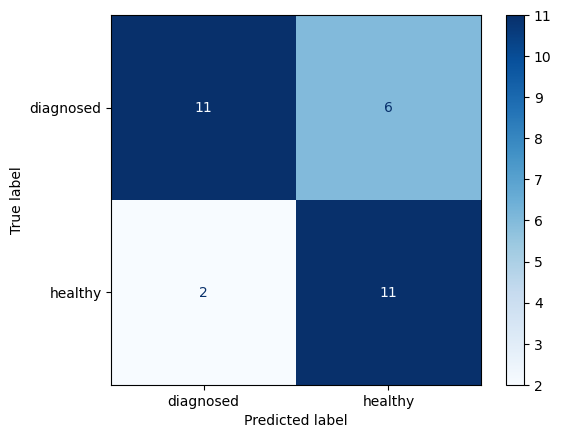

In [265]:
print(classification_report(y_test, y_pred_underSamplerGr))
cm=confusion_matrix(y_test, y_pred_underSamplerGr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [266]:
best_models

{'adaboost orgein data': {'best_score': 84.52380952380952,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost grid_search Org ': {'best_score': 82.85714285714286,
  'best_params': {'learning_rate': 0.01, 'n_estimators': 50}},
 'AdaBoost Oversampel ': {'best_score': 86.66666666666666,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost Grid search Oversampel ': {'best_score': 88.09523809523809,
  'best_params': {'learning_rate': 0.001, 'n_estimators': 50}},
 'AdaBoost undersampel ': {'best_score': 81.9047619047619,
  'best_params': {'algorithm': 'SAMME.R',
   'base_estimator': 'deprecated',
   'estimator': None,
   'learning_rate': 1.0,
   'n_estimators': 50,
   'random_state': None}},
 'AdaBoost Grid search undersampel ': {

In [267]:
import pandas as pd

df = pd.DataFrame.from_dict(best_models, orient='index')
df= df.sort_values(by=['best_score'],ascending=False)
df

,best_score,best_params
AdaBoost Grid search Oversampel,88.095238,"{'learning_rate': 0.001, 'n_estimators': 50}"
AdaBoost Oversampel,86.666667,"{'algorithm': 'SAMME.R', 'base_estimator': 'de..."
adaboost orgein data,84.523810,"{'algorithm': 'SAMME.R', 'base_estimator': 'de..."
AdaBoost grid_search Org,82.857143,"{'learning_rate': 0.01, 'n_estimators': 50}"
AdaBoost Grid search undersampel,82.380952,"{'learning_rate': 0.1, 'n_estimators': 50}"
AdaBoost undersampel,81.904762,"{'algorithm': 'SAMME.R', 'base_estimator': 'de..."
